In [1]:
import sys
sys.path.insert(0, "..")
from classes.calculators.lennardjones import LJGauss
import matplotlib.pyplot as plt
import torch
import numpy as np

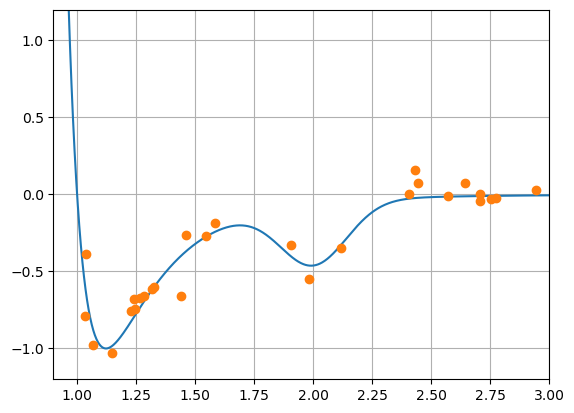

In [27]:
fig, ax = plt.subplots()
ax.grid()
lj_gauss = LJGauss(r0=2.0, gauss_eps=0.4)
rs = np.linspace(0.8, 3.0, 1000)
r_rand = (3.0-0.95)*np.random.rand(30) + 0.95
lj_rand = lj_gauss(r_rand) + np.random.randn(len(r_rand))*1e-1
ax.set_xlim([0.9, 3.0])
ax.set_ylim([-1.2,1.2])
ax.plot(rs, lj_gauss(rs))
ax.plot(r_rand,lj_rand, 'o')

In [28]:
class LJGNN(torch.nn.Module):
    def __init__(self, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.acc_func = activation_func
        self.hidden_layers = torch.nn.ParameterList()
        self.input_layer = torch.nn.Linear(1, dim_hiddens, bias=bias)
        self.output_layer = torch.nn.Linear(dim_hiddens, 1, bias=bias)
        for num in range(num_hidden_layers):
            self.hidden_layers.append(torch.nn.Linear(dim_hiddens, dim_hiddens, bias=bias))

    def forward(self, x):
        x = self.acc_func(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.acc_func(layer(x))
        return self.output_layer(x)
    
def train_model(model, train_rs, pred_ys, optimizer, N_steps=5000,loss_func=torch.nn.MSELoss()):
    loss_vals = []
    for step in range(N_steps):
        optimizer.zero_grad()
        loss = loss_func(pred_ys, model.forward(train_rs))
        loss_vals.append(loss)
        loss.backward()
        optimizer.step()
    return loss_vals

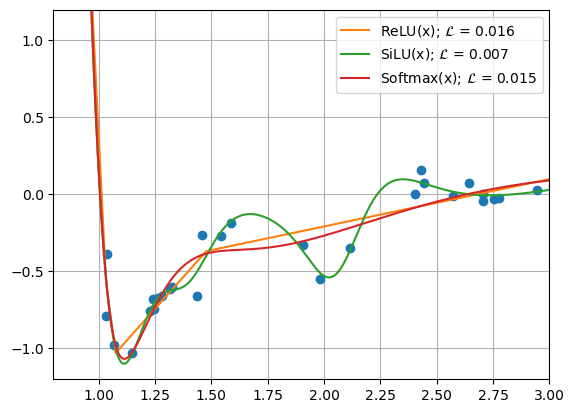

In [60]:
fig, ax = plt.subplots()
activation_functions = {"ReLU(x)":torch.nn.ReLU(), 
                        "SiLU(x)":torch.nn.SiLU(), 
                        "Softmax(x)":torch.nn.Softplus()
                        }

rs = torch.linspace(0.8, 3.0, 2000).reshape(-1,1)
ax.set_xlim([0.8, 3.0])
ax.set_ylim([-1.2,1.2])
ax.grid()
ax.plot(r_rand,lj_rand, 'o')
for activation_func in activation_functions:
    model = LJGNN(num_hidden_layers=2, dim_hiddens=8, activation_func=activation_functions[activation_func], bias=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    loss_vals = train_model(model=model, train_rs=torch.tensor(r_rand, dtype=torch.float).view(-1, 1), pred_ys=torch.tensor(lj_rand, dtype=torch.float).view(-1, 1), optimizer=optimizer, N_steps=20000)
    with torch.no_grad():
        val = str(loss_vals[-1].numpy().round(3))
        ax.plot(rs, model.forward(rs), label=f"{activation_func}; " r"$\mathcal{L}$ = "+f"{val}")
ax.legend(loc="upper right")

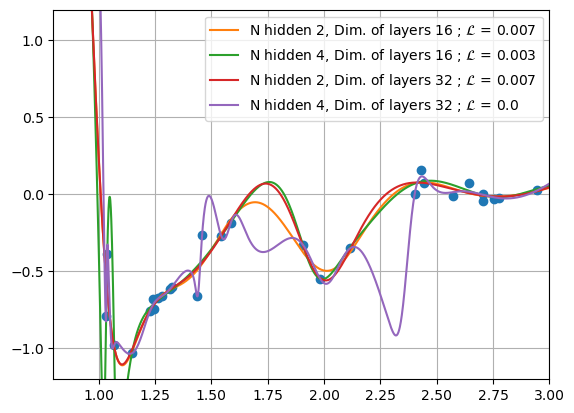

In [59]:
fig, ax = plt.subplots()
layer_geometries = {"1":(2, 16), #(num layers, dim. of layers)
                    "2":(4, 16),
                    "3":(2,32),
                    "4":(4,32)
                    }

rs = torch.linspace(0.8, 3.0, 2000).reshape(-1,1)
ax.set_xlim([0.8, 3.0])
ax.set_ylim([-1.2,1.2])
ax.grid()
ax.plot(r_rand,lj_rand, 'o')
for layer_geom in layer_geometries:
    num_hiddens, dim_hiddens = layer_geometries[layer_geom]
    model = LJGNN(num_hidden_layers=num_hiddens, dim_hiddens=dim_hiddens, activation_func=torch.nn.SiLU(), bias=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    loss_vals = train_model(model=model, train_rs=torch.tensor(r_rand, dtype=torch.float).view(-1, 1), pred_ys=torch.tensor(lj_rand, dtype=torch.float).view(-1, 1), optimizer=optimizer, N_steps=20000)
    with torch.no_grad():
        val = str(loss_vals[-1].numpy().round(3))
        ax.plot(rs, model.forward(rs), label=f"N hidden {num_hiddens}, Dim. of layers {dim_hiddens} ; "+r"$\mathcal{L}$ = "+f"{val}")
ax.legend(loc="upper right")

In [61]:
small_models_trained = []
large_models_trained = []
for i in range(100):
    model_small = LJGNN(num_hidden_layers=2, dim_hiddens=8, activation_func=torch.nn.SiLU(), bias=True)
    model_large = LJGNN(num_hidden_layers=4, dim_hiddens=32, activation_func=torch.nn.SiLU(), bias=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    models = [model_small, model_large]
    for model in models:
        loss_vals = train_model(model=model_small, train_rs=torch.tensor(r_rand, dtype=torch.float).view(-1, 1), pred_ys=torch.tensor(lj_rand, dtype=torch.float).view(-1, 1), optimizer=optimizer, N_steps=10000)
    small_models_trained.append(model_small)
    large_models_trained.append(model_large)

KeyboardInterrupt: 